In [640]:
%matplotlib inline

In [641]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('Set2')

In [642]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [643]:
latest_niv = get_latest_file_glob('data/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

test_date  cough  fever  sore_throat  shortness_of_breath  head_ache  \
0 2020-09-13      0      0            0                    0          0   
1 2020-09-13      0      0            0                    0          0   
2 2020-09-13      0      0            0                    0          0   
3 2020-09-13      0      0            0                    0          0   
4 2020-09-13      0      0            0                    0          0   

  corona_result age_60_and_above gender test_indication  
0         שלילי               No    זכר           Other  
1         שלילי               No    זכר           Other  
2           אחר               No    זכר           Other  
3         שלילי               No    זכר           Other  
4         שלילי               No    זכר           Other

In [644]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [645]:
latest_bdi = get_latest_file_glob('data/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [646]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [647]:
bdi.head()

test_date result_date corona_result  lab_id  test_for_corona_diagnosis  \
0 2020-08-09  2020-08-09         שלילי       2                          1   
1 2020-08-09  2020-08-09         חיובי       2                          1   
2 2020-08-10  2020-08-10         שלילי       2                          1   
3 2020-03-11  2020-03-11         חיובי      32                          0   
4 2020-03-11  2020-03-11         שלילי      32                          0   

  is_first_Test orig_test_date  
0           Yes            NaT  
1            No            NaT  
2           Yes            NaT  
3            No     2020-03-11  
4            No     2020-03-11

In [648]:
bdi.shape

(2924064, 7)

In [649]:
niv.corona_result.value_counts()

שלילי    1607780
חיובי     122567
אחר        23469
Name: corona_result, dtype: int64

In [650]:
bdi.corona_result.value_counts()

שלילי               2662702
חיובי                205561
לא בוצע/פסול 999      28286
חיובי גבולי           26502
בעבודה                  614
לא ודאי                 399
Name: corona_result, dtype: int64

In [651]:
niv.corona_result.value_counts()

שלילי    1607780
חיובי     122567
אחר        23469
Name: corona_result, dtype: int64

In [652]:
niv.test_indication.value_counts()

Other                     1645613
Contact with confirmed      82624
Abroad                      25579
Name: test_indication, dtype: int64

In [653]:
niv.age_60_and_above.value_counts()

No     1097775
Yes     157133
Name: age_60_and_above, dtype: int64

In [654]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [655]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [656]:
bdi_result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'חיובי גבולי': 'borderline',
    'לא בוצע/פסול 999': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
bdi['corona_result'] = bdi.corona_result.map(bdi_result_map)

In [657]:
bdi.corona_result.value_counts()

negative       2662702
positive        205561
not_done         28286
borderline       26502
in_progress        614
uncertain          399
Name: corona_result, dtype: int64

In [658]:
rec = pd.read_csv(get_latest_file_glob('data/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

In [659]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

total_tests_count   size  min  max       mean  median  test_sum
0                  2      6    6   17  12.833333      13        12
1                  3  11061    2  112  16.665582      17     33183
2                  4   5081    2  114  21.462114      21     20324
3                  5   3127    2  106  24.647905      25     15635
4                  6   1786    6   96  27.668533      27     10716
5                  7   1063    8  108  30.398871      30      7441
6                  8    597    3  103  33.475712      33      4776
7                  9    357    3   78  35.700280      35      3213
8                 10    573    5  106  41.130890      41      5730

In [660]:
(rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('10+', '11').replace('11+', '12')
                                .astype(int)))
 .total_tests_count.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()

index  total_tests_count
0    size       23651.000000
1     min           2.000000
2     max          12.000000
3    mean           4.320156
4  median           4.000000

In [661]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]


days_between_pos_and_neg total_tests_count age_group gender  \
9432                        114                 4       60+    זכר   
12342                       112                 3     30-39    זכר   
9304                        111                 4     20-29    זכר   
1600                        108                 7     40-49   נקבה   
6311                        106                 5     30-39    זכר   
23175                       106               10+      0-19   נקבה   
9696                        105                 4     30-39   נקבה   
456                         103                 8     50-59   נקבה   
20936                       103                 3      0-19    זכר   
23273                       100               10+       60+    זכר   

              test_indication  
9432                    Other  
12342  Contact with confirmed  
9304                    Other  
1600   Contact with confirmed  
6311   Contact with confirmed  
23175  Contact with confirmed  
9696                    Other  
456    Contact with confirmed  
20936                  Abroad  
23273  Contact with confirmed

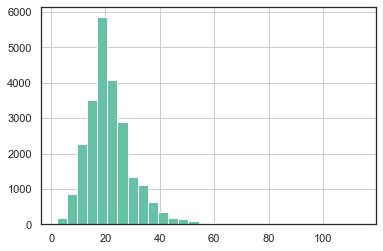

In [662]:
rec.days_between_pos_and_neg.hist(bins=30)

In [663]:
iso = pd.read_csv(get_latest_file_glob('data/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

date  isolated_today_contact_with_confirmed  isolated_today_abroad  \
0  2020-09-12                                 114989                  23251   
1  2020-09-11                                 111423                  23867   
2  2020-09-10                                 106397                  25466   
3  2020-09-09                                  97110                  25703   
4  2020-09-08                                  87857                  26032   

  new_contact_with_confirmed new_from_abroad  
0                      10412             735  
1                      13396            1019  
2                      17325            1659  
3                      17158            1340  
4                      16560            1293

In [664]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [665]:
niv.age_60_and_above.value_counts()

No     1097775
Yes     157133
Name: age_60_and_above, dtype: int64

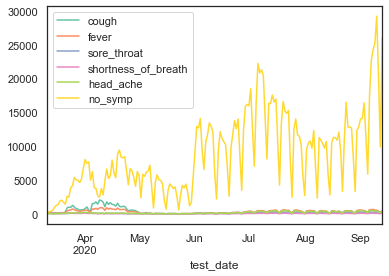

In [666]:
niv.groupby('test_date')[symptom_cols].sum().plot()

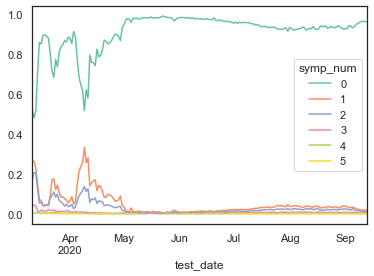

In [667]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

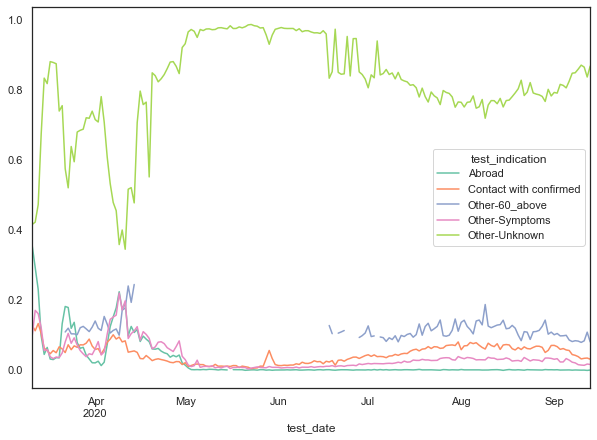

In [668]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

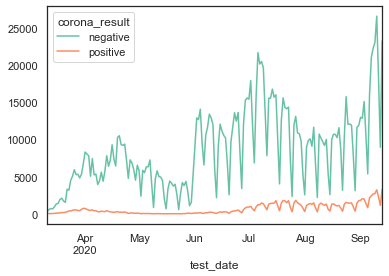

In [669]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [670]:
bdi.dtypes

test_date                    datetime64[ns]
result_date                  datetime64[ns]
corona_result                        object
lab_id                                int64
test_for_corona_diagnosis             int64
is_first_Test                        object
orig_test_date               datetime64[ns]
dtype: object

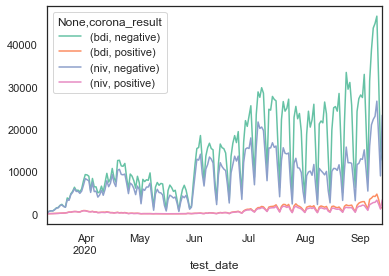

In [671]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

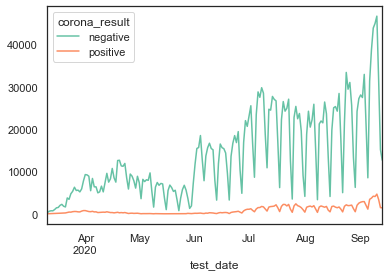

In [672]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [673]:
pone = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result  borderline  in_progress  negative  not_done  positive  \
test_date                                                              
2020-03-11            NaN         17.0     319.0       NaN      18.0   
2020-05-09            NaN          NaN    1586.0      59.0      12.0   
2020-05-14           46.0          2.0    7057.0      80.0      19.0   
2020-05-15            5.0          NaN    3734.0      53.0      10.0   
2020-05-16            NaN          NaN     989.0      45.0       5.0   
2020-05-17           11.0          NaN    5508.0      98.0      17.0   
2020-05-20            9.0          NaN    5286.0      62.0      19.0   
2020-05-23            1.0          NaN     750.0      39.0       3.0   
2020-05-24            3.0          NaN    3714.0      91.0       6.0   

corona_result  uncertain  
test_date                 
2020-03-11           1.0  
2020-05-09           NaN  
2020-05-14           NaN  
2020-05-15           NaN  
2020-05-16           NaN  
2020-05-17           NaN  
2020-05-20           NaN  
2020-05-23           NaN  
2020-05-24           NaN

In [674]:
pone.tail(5)

corona_result  borderline  in_progress  negative  not_done  positive  \
test_date                                                              
2020-09-09          510.0          NaN   44943.0     286.0    4089.0   
2020-09-10          457.0          NaN   46662.0     205.0    4650.0   
2020-09-11          396.0          NaN   31550.0     147.0    3375.0   
2020-09-12          129.0          NaN   15146.0      82.0    1466.0   
2020-09-13           74.0          NaN   12647.0     146.0    1423.0   

corona_result  uncertain  
test_date                 
2020-09-09           NaN  
2020-09-10           NaN  
2020-09-11           NaN  
2020-09-12           NaN  
2020-09-13           NaN

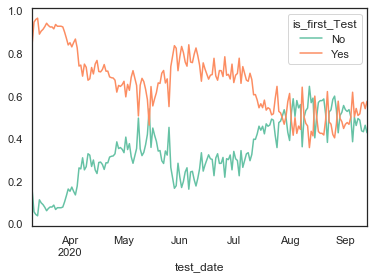

In [675]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

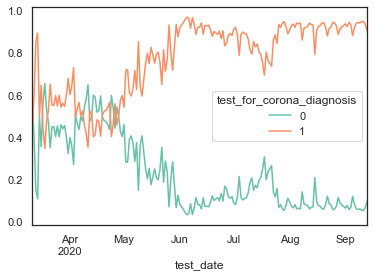

In [676]:
ti = bdi[(bdi.is_first_Test=='No')].groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

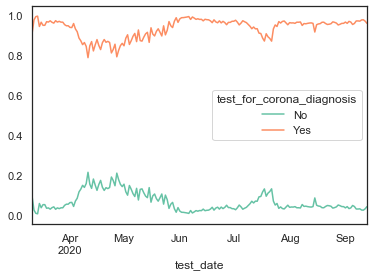

In [677]:
ti = bdi.groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
ti = ti.rename(columns={0: 'No', 1: 'Yes'})
(ti.div(ti.sum(axis=1), axis=0)).plot()

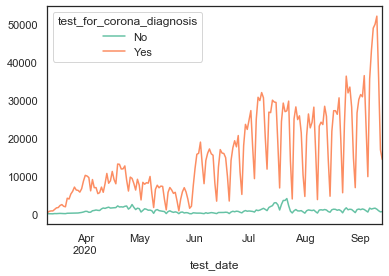

In [678]:
ti.plot()

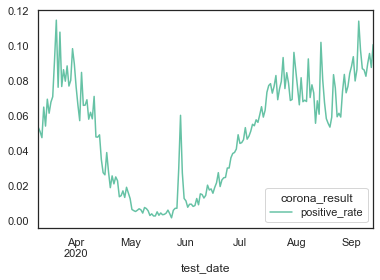

In [679]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain))[['positive_rate']]
 .plot())

In [680]:
import altair as alt

In [681]:
ti.tail()

test_for_corona_diagnosis    No    Yes
test_date                             
2020-09-09                 1490  49828
2020-09-10                 1220  51974
2020-09-11                  809  35468
2020-09-12                  509  16823
2020-09-13                  600  14290

In [682]:
ti.Yes.sum() + ti.No.sum()

2924064

In [683]:
alt.Chart(ti.reset_index().assign(total=lambda x: (x.Yes+x.No))).mark_line().encode(
    x='test_date',
    y='total',
    tooltip=['test_date', 'total']
).interactive()

alt.Chart(...)

In [684]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [685]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [686]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')
          ]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [687]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [688]:
hos = (pd.read_csv(get_latest_file_glob('data/corona_hospitalization_ver_*.csv.gz'), encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

date  מאושפזים  אחוז נשים מאושפזות  גיל ממוצע מאושפזים  \
0 2020-03-11        76                35.5                48.0   
1 2020-03-12        98                38.8                50.0   
2 2020-03-13       116                38.8                49.0   
3 2020-03-14       154                40.9                47.0   
4 2020-03-15       193                44.0                47.0   

   סטיית תקן גיל מאושפזים  resp  אחוז נשים מונשמות  גיל ממוצע מונשמים  \
0                    17.3    15               20.0               63.0   
1                    18.0    15               20.0               63.0   
2                    17.9    15               20.0               63.0   
3                    18.2    15                0.0               70.0   
4                    18.5    15               20.0               74.0   

   סטיית תקן גיל מונשמים  חולים קל  ...  גיל ממוצע חולים קל  \
0                   15.3        69  ...                47.0   
1                   15.3        91  ...                49.0   
2                   15.3       106  ...                47.0   
3                    7.4       145  ...                46.0   
4                    7.6       179  ...                45.0   

   סטיית תקן גיל חולים קל  medium  אחוז נשים חולות בינוני  \
0                    16.7      15                     NaN   
1                    17.7      15                     NaN   
2                    17.3      15                    50.0   
3                    17.4      15                    50.0   
4                    17.5      15                    50.0   

   גיל ממוצע חולים בינוני  סטיית תקן גיל חולים בינוני  critical  \
0                     NaN                         NaN        15   
1                     NaN                         NaN        15   
2                    65.0                        17.3        15   
3                    65.0                        17.3        15   
4                    58.0                        14.9        15   

   אחוז נשים חולות קשה  גיל ממוצע חולים קשה  סטיית תקן גיל חולים קשה  
0                 33.3                 67.0                     16.2  
1                 33.3                 67.0                     16.2  
2                 33.3                 67.0                     16.2  
3                 20.0                 76.0                     10.3  
4                 37.5                 79.0                      9.1  

[5 rows x 21 columns]

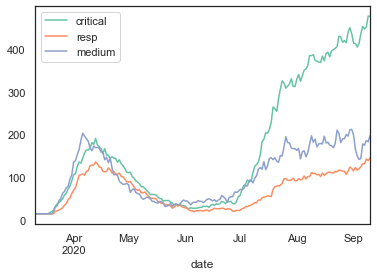

In [689]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [690]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


test_date  critical  resp  medium  borderline  in_progress  negative  \
0 2020-03-11        15    15      15         0.0         19.0     323.0   
1 2020-03-12        15    15      15         0.0          2.0     617.0   
2 2020-03-13        15    15      15         0.0          0.0     723.0   
3 2020-03-14        15    15      15         0.0          3.0     706.0   
4 2020-03-15        15    15      15         0.0         93.0    1030.0   

   not_done  positive  uncertain  positive_rate  
0       0.0      46.0        1.0       0.124324  
1       3.0      47.0        0.0       0.070783  
2       6.0      41.0        0.0       0.053665  
3       5.0      52.0        0.0       0.068602  
4      20.0     111.0        0.0       0.097283

In [691]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [692]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


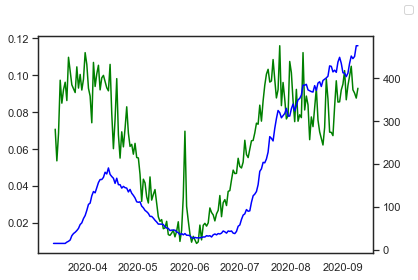

In [693]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [694]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [695]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [696]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

## Positive rate by Lab

In [697]:
polab = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)].fillna('Other').groupby(['test_date', 'lab_id', 'corona_result']).size().unstack().fillna(0)
polab['total_tests'] = polab.sum(axis=1)
polab['positive_rate'] = polab.positive/(polab.positive+polab.negative+polab.borderline+polab.uncertain)

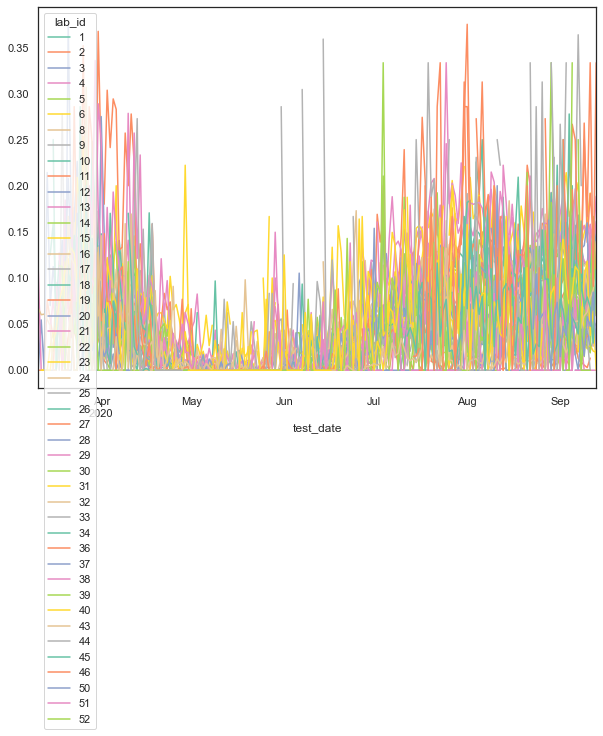

In [698]:
polab[polab.positive_rate<0.4].positive_rate.unstack().plot(figsize=(10,7))

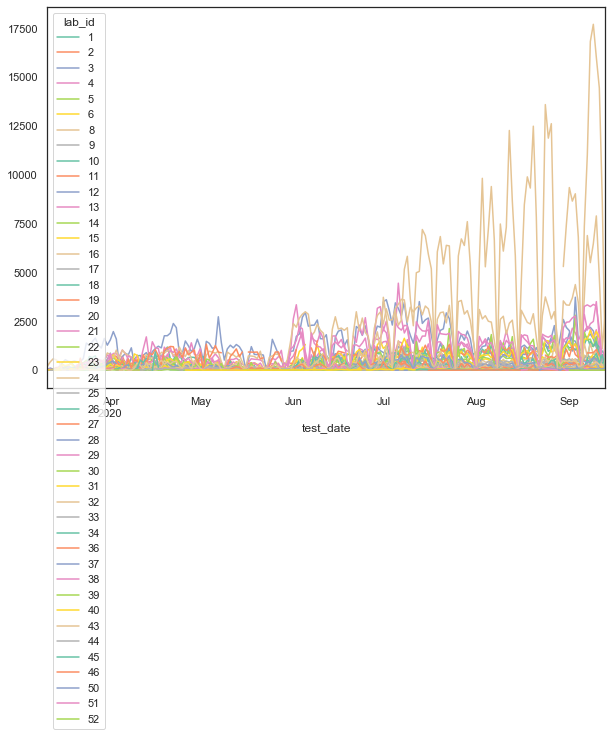

In [699]:
polab.total_tests.unstack().plot(figsize=(10,7))

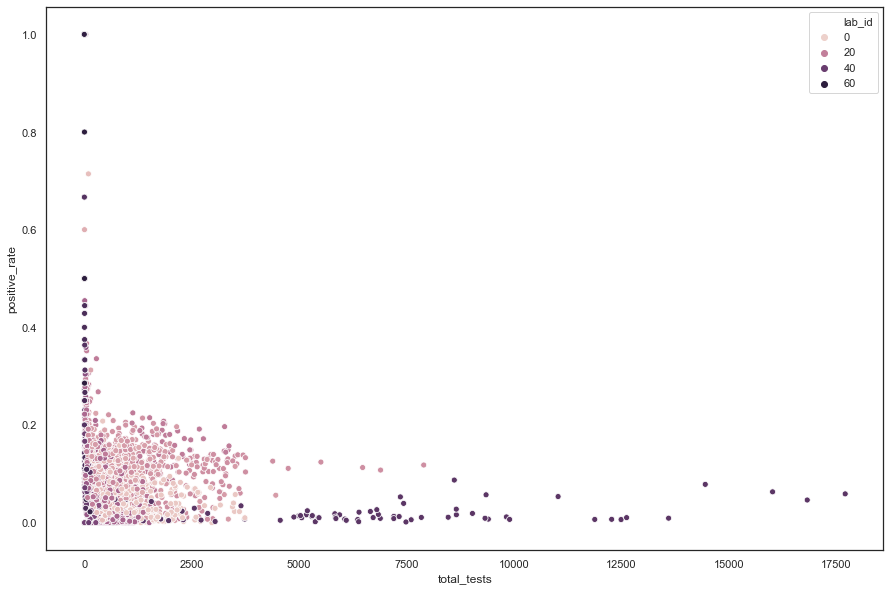

In [700]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=polab.reset_index(), x='total_tests', y='positive_rate', hue='lab_id')


In [701]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [702]:
alt.Chart(polab.reset_index()).mark_point().encode(
    x='total_tests',
    y='positive_rate',
    color='lab_id:N',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [703]:
(polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1)))

corona_result  positive  negative  total_tests  positive_rate
lab_id                                                       
43              10794.0  462951.0     478168.0            1.2
16              26331.0  291455.0     318964.0            4.5
3                8419.0  247980.0     258275.0            1.7
13              15968.0  175255.0     196275.0            4.6
21              21194.0  158493.0     181644.0            6.7
4                6562.0  107506.0     116040.0            3.1
10               7927.0  104456.0     115853.0            3.8
15              11358.0   90460.0     103476.0            6.3
27               1047.0   99708.0     100844.0            0.5
12               8176.0   87823.0      98093.0            4.7
14               6171.0   81558.0      88723.0            3.8
6                1928.0   65007.0      69416.0            1.5
5                2903.0   60134.0      64611.0            2.4
24               2473.0   53780.0      58823.0            2.3
18               2752.0   47900.0      51110.0            2.9
2                1237.0   48306.0      49672.0            1.3
8                3718.0   42934.0      47048.0            4.3
28               2526.0   38092.0      40760.0            3.3
22               1396.0   34042.0      37047.0            2.1
17               1541.0   27908.0      30137.0            2.8
32                942.0   27924.0      28982.0            1.7
25               1075.0   26040.0      28452.0            2.1
9                1389.0   25722.0      28300.0            2.7
11               1813.0   24906.0      27250.0            3.6
19               1939.0   17524.0      19860.0            5.5
33                409.0   18549.0      19088.0            1.1
23               1006.0   16776.0      18148.0            3.0
26               1221.0   15753.0      17326.0            3.9
36                174.0   16359.0      16731.0            0.5
20                443.0   13208.0      13776.0            1.7
29                596.0    8902.0       9612.0            3.3
31                281.0    5376.0       5719.0            2.6
30                116.0    4586.0       4772.0            1.3
40                289.0    4066.0       4443.0            3.6
34                100.0    2641.0       2766.0            1.9
45                155.0    2391.0       2557.0            3.2
38                 35.0    2310.0       2353.0            0.8
39                103.0    1955.0       2116.0            2.6
37                 13.0    1710.0       1735.0            0.4
50                 80.0    1395.0       1484.0            2.9
51                  8.0     766.0        786.0            0.5
46                114.0     517.0        631.0           11.0
44                 84.0     527.0        611.0            8.0
1                  17.0      53.0         78.0           16.0
52                 12.0      36.0         48.0           16.7

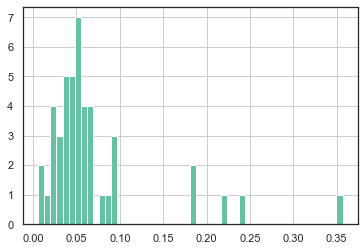

In [704]:
polab.reset_index().groupby('lab_id').positive_rate.mean().hist(bins=50)

In [705]:
top_5_labs = bdi[(bdi.test_for_corona_diagnosis==1)].lab_id.value_counts().index[:10]
top_5_labs

Int64Index([43, 16, 3, 13, 21, 4, 10, 15, 27, 12], dtype='int64')

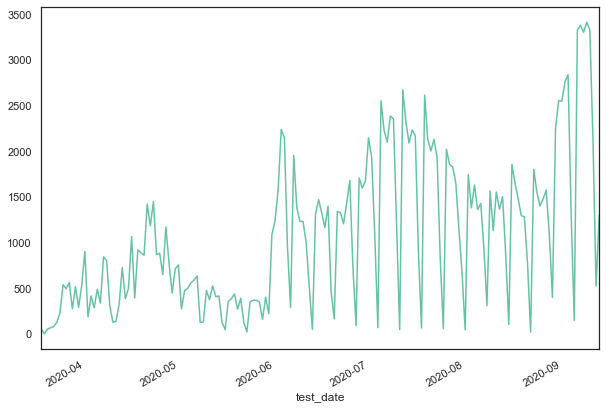

In [706]:
bdi[(bdi.lab_id==21)].groupby('test_date').size().plot(figsize=(10,7))

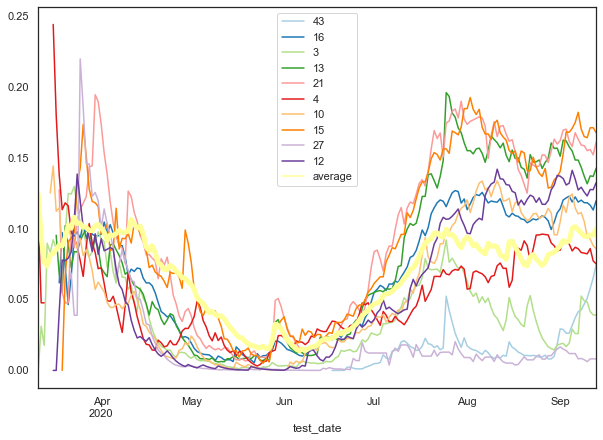

In [707]:
sns.set_palette(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928'])
forp = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1).ewm(span=7).mean()
ax = forp[forp<0.3].plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


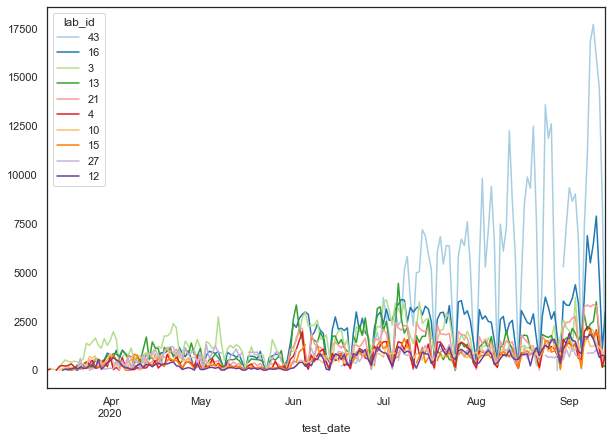

In [708]:
forp = polab.total_tests.unstack()[top_5_labs]
ax = forp.plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


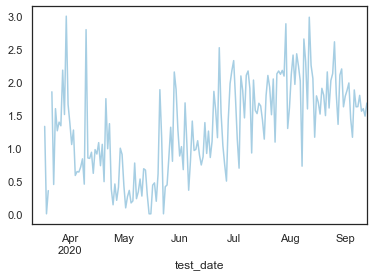

In [709]:
top_labs_pr = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1)
top_labs_pr['ratio_21'] = top_labs_pr.loc[:, 21]/top_labs_pr.average
top_labs_pr.ratio_21.plot()

In [710]:
bdi[bdi.lab_id==21].shape[0]/bdi.shape[0]

0.06591955579631636

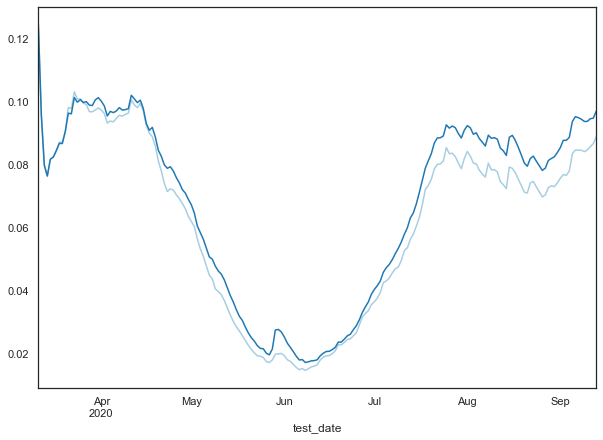

In [711]:
ax = (bdi[~(bdi.lab_id.isin([13,21]))].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo.ewm(7).mean().plot(figsize=(10,7))
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr.ewm(7).mean().plot(ax=ax, figsize=(10,7))

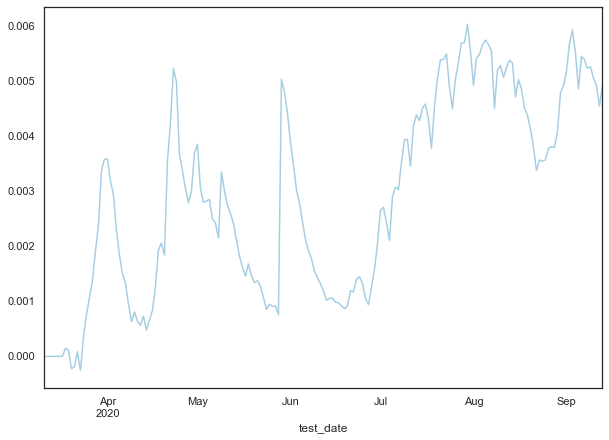

In [712]:
pd.concat([(bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo,
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr], axis=1).assign(dif = lambda x: x.pr-x.pr_wo).dif.ewm(7).mean().plot(figsize=(10,7))

In [713]:
alt.Chart(polab[polab.total_tests>100].reset_index()).mark_point(size=2).encode(
    x='test_date',
    y='total_tests',
    color='positive_rate:Q',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [714]:
xx = (polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1))
 .assign(positive_rq = lambda x: pd.qcut(x.positive_rate, 5))
)
xx

corona_result  positive  negative  total_tests  positive_rate    positive_rq
lab_id                                                                      
43              10794.0  462951.0     478168.0            1.2  (0.399, 1.46]
16              26331.0  291455.0     318964.0            4.5   (3.24, 4.52]
3                8419.0  247980.0     258275.0            1.7   (1.46, 2.52]
13              15968.0  175255.0     196275.0            4.6   (4.52, 16.7]
21              21194.0  158493.0     181644.0            6.7   (4.52, 16.7]
4                6562.0  107506.0     116040.0            3.1   (2.52, 3.24]
10               7927.0  104456.0     115853.0            3.8   (3.24, 4.52]
15              11358.0   90460.0     103476.0            6.3   (4.52, 16.7]
27               1047.0   99708.0     100844.0            0.5  (0.399, 1.46]
12               8176.0   87823.0      98093.0            4.7   (4.52, 16.7]
14               6171.0   81558.0      88723.0            3.8   (3.24, 4.52]
6                1928.0   65007.0      69416.0            1.5   (1.46, 2.52]
5                2903.0   60134.0      64611.0            2.4   (1.46, 2.52]
24               2473.0   53780.0      58823.0            2.3   (1.46, 2.52]
18               2752.0   47900.0      51110.0            2.9   (2.52, 3.24]
2                1237.0   48306.0      49672.0            1.3  (0.399, 1.46]
8                3718.0   42934.0      47048.0            4.3   (3.24, 4.52]
28               2526.0   38092.0      40760.0            3.3   (3.24, 4.52]
22               1396.0   34042.0      37047.0            2.1   (1.46, 2.52]
17               1541.0   27908.0      30137.0            2.8   (2.52, 3.24]
32                942.0   27924.0      28982.0            1.7   (1.46, 2.52]
25               1075.0   26040.0      28452.0            2.1   (1.46, 2.52]
9                1389.0   25722.0      28300.0            2.7   (2.52, 3.24]
11               1813.0   24906.0      27250.0            3.6   (3.24, 4.52]
19               1939.0   17524.0      19860.0            5.5   (4.52, 16.7]
33                409.0   18549.0      19088.0            1.1  (0.399, 1.46]
23               1006.0   16776.0      18148.0            3.0   (2.52, 3.24]
26               1221.0   15753.0      17326.0            3.9   (3.24, 4.52]
36                174.0   16359.0      16731.0            0.5  (0.399, 1.46]
20                443.0   13208.0      13776.0            1.7   (1.46, 2.52]
29                596.0    8902.0       9612.0            3.3   (3.24, 4.52]
31                281.0    5376.0       5719.0            2.6   (2.52, 3.24]
30                116.0    4586.0       4772.0            1.3  (0.399, 1.46]
40                289.0    4066.0       4443.0            3.6   (3.24, 4.52]
34                100.0    2641.0       2766.0            1.9   (1.46, 2.52]
45                155.0    2391.0       2557.0            3.2   (2.52, 3.24]
38                 35.0    2310.0       2353.0            0.8  (0.399, 1.46]
39                103.0    1955.0       2116.0            2.6   (2.52, 3.24]
37                 13.0    1710.0       1735.0            0.4  (0.399, 1.46]
50                 80.0    1395.0       1484.0            2.9   (2.52, 3.24]
51                  8.0     766.0        786.0            0.5  (0.399, 1.46]
46                114.0     517.0        631.0           11.0   (4.52, 16.7]
44                 84.0     527.0        611.0            8.0   (4.52, 16.7]
1                  17.0      53.0         78.0           16.0   (4.52, 16.7]
52                 12.0      36.0         48.0           16.7   (4.52, 16.7]

In [715]:
polab = polab.reset_index()
polab['total_pr'] = polab.lab_id.map(xx.positive_rate)
polab['total_prq'] = polab.lab_id.map(xx.positive_rq)
polab = polab.set_index(['test_date', 'lab_id'])
polab.head()

corona_result      borderline  in_progress  negative  not_done  positive  \
test_date  lab_id                                                          
2020-03-11 1              0.0          0.0       0.0       0.0       2.0   
           2              0.0          0.0      70.0       0.0       0.0   
           3              0.0          1.0      36.0       0.0       0.0   
           4              0.0          0.0      16.0       0.0       2.0   
           6              0.0         16.0       0.0       0.0       0.0   

corona_result      uncertain  total_tests  positive_rate  total_pr  \
test_date  lab_id                                                    
2020-03-11 1             0.0          2.0       1.000000      16.0   
           2             0.0         70.0       0.000000       1.3   
           3             1.0         38.0       0.000000       1.7   
           4             0.0         18.0       0.111111       3.1   
           6             0.0         16.0            NaN       1.5   

corona_result          total_prq  
test_date  lab_id                 
2020-03-11 1        (4.52, 16.7]  
           2       (0.399, 1.46]  
           3        (1.46, 2.52]  
           4        (2.52, 3.24]  
           6        (1.46, 2.52]

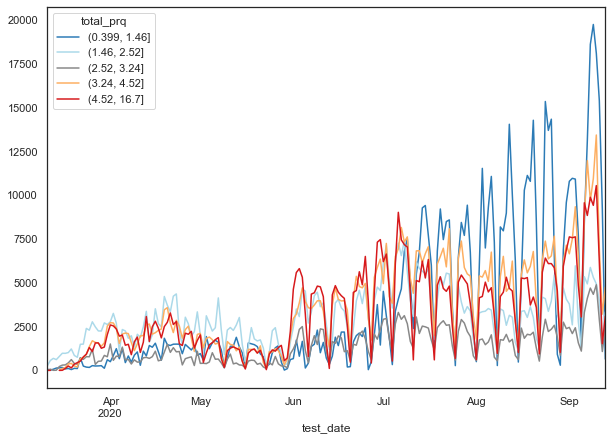

In [716]:
sns.set_palette(['#d7191c','#fdae61','#888888','#abd9e9','#2c7bb6'][::-1])
#sns.set_palette(['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000'])
sns.set_style('white')
prq = (polab.reset_index()
 .groupby(['test_date', 'total_prq']).total_tests.sum()
 .unstack()
)
prq.plot(figsize=(10,7))

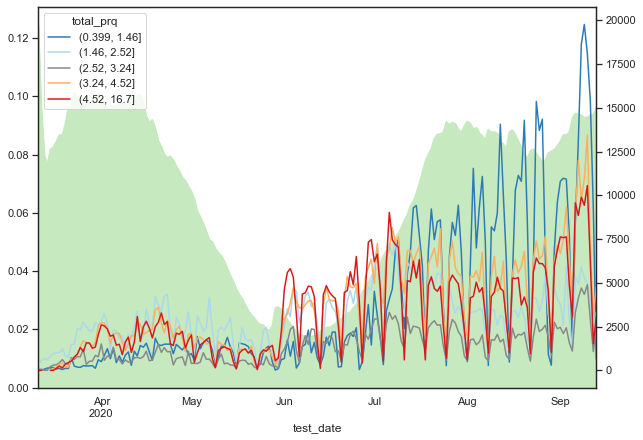

In [717]:
ax=(bdi.groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
    .assign(pr = lambda x: x.positive/(x.negative+x.positive+x.borderline+x.uncertain))
   ).pr.ewm(7).mean().plot(color='#c7e9c0', kind='area', figsize=(10,7))
ax2=ax.twinx()
prq.plot(ax=ax2)

## Decseased 

In [718]:
last_dec = pd.read_csv(get_latest_file_glob('data/corona_deceased_ver*.csv.gz'), 
                       encoding='utf-8-sig', low_memory=False)
last_dec['qc'] = pd.qcut(last_dec.Length_of_hospitalization, 11, duplicates='drop')
last_dec.qc.value_counts().sort_index()/len(last_dec)

(-0.001, 3.0]     0.218722
(3.0, 5.0]        0.086409
(5.0, 7.0]        0.101710
(7.0, 9.0]        0.088209
(9.0, 10.545]     0.045905
(10.545, 13.0]    0.095410
(13.0, 17.0]      0.096310
(17.0, 21.0]      0.084608
(21.0, 29.0]      0.085509
(29.0, 154.0]     0.089109
Name: qc, dtype: float64

In [719]:
sns.set_palette('Set2')


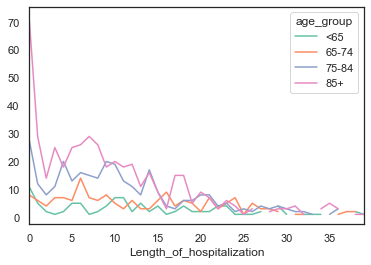

In [720]:
x = last_dec[last_dec['Length_of_hospitalization']<40].groupby(['Length_of_hospitalization', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.plot()

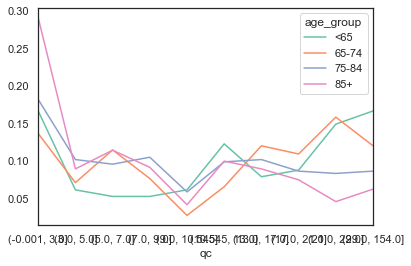

In [721]:
x = last_dec.groupby(['qc', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=0), axis=1).plot()

In [722]:
(last_dec.Length_of_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

0.0    0.107111
1.0    0.046805
2.0    0.025203
3.0    0.039604
4.0    0.042304
5.0    0.044104
6.0    0.054905
7.0    0.046805
8.0    0.043204
9.0    0.045005
Name: Length_of_hospitalization, dtype: float64

In [723]:
(last_dec.Time_between_positive_and_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

-141.0    0.0009
-36.0     0.0009
-25.0     0.0009
-21.0     0.0018
-16.0     0.0009
-15.0     0.0018
-14.0     0.0018
-12.0     0.0009
-11.0     0.0018
-9.0      0.0018
Name: Time_between_positive_and_hospitalization, dtype: float64

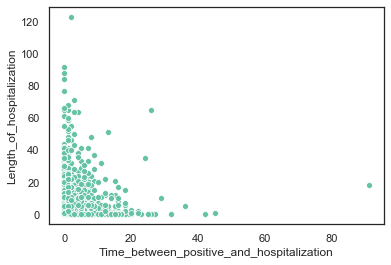

In [724]:
sns.scatterplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='Time_between_positive_and_hospitalization', y='Length_of_hospitalization')

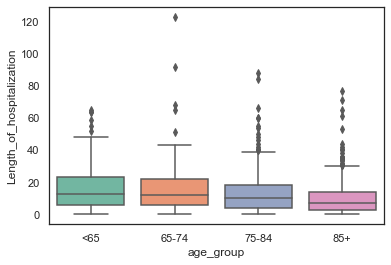

In [725]:
sns.boxplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='age_group', y='Length_of_hospitalization', order=['<65', '65-74', '75-84', '85+'])

In [726]:
decs = []
for file in sorted(glob.glob('data/corona_deceased_ver*.csv.gz'), key=os.path.getctime) :
    dec = pd.read_csv(file, 
                  encoding='utf-8-sig', low_memory=False)
    dec['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    dec.time = dec.time
    dec['file'] = file
    decs.append(dec)

decs = pd.concat(decs).sort_values('time')
decs.head()

gender age_group  Ventilated  Time_between_positive_and_hospitalization  \
0      זכר       <65         1.0                                        2.0   
203   נקבה     75-84         1.0                                        0.0   
202   נקבה       85+         0.0                                       10.0   
201   נקבה       85+         0.0                                        2.0   
200    זכר       85+         1.0                                        0.0   

     Length_of_hospitalization  Time_between_positive_and_death  \
0                         20.0                               22   
203                       12.0                               12   
202                        1.0                               11   
201                       17.0                               19   
200                        9.0                                9   

                   time                                 file  
0   2020-06-16 12:09:51  data\corona_deceased_ver_001.csv.gz  
203 2020-06-16 12:09:51  data\corona_deceased_ver_001.csv.gz  
202 2020-06-16 12:09:51  data\corona_deceased_ver_001.csv.gz  
201 2020-06-16 12:09:51  data\corona_deceased_ver_001.csv.gz  
200 2020-06-16 12:09:51  data\corona_deceased_ver_001.csv.gz

In [727]:
decs.shape, (decs.drop_duplicates(subset=['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death']).shape)

((15668, 8), (907, 8))

In [728]:
decs.columns

Index(['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death', 'time',
       'file'],
      dtype='object')

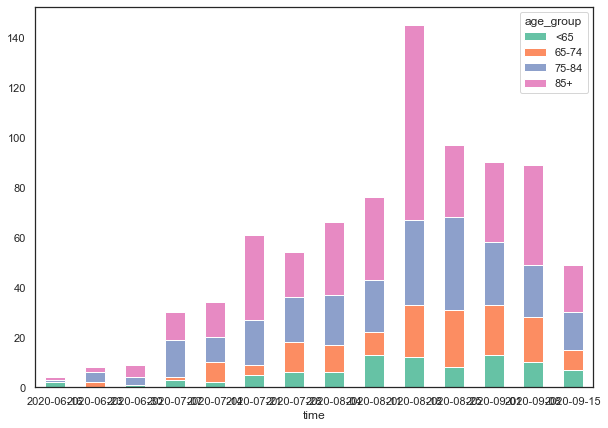

In [729]:
dec_dif = decs.groupby(['time', 'age_group']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

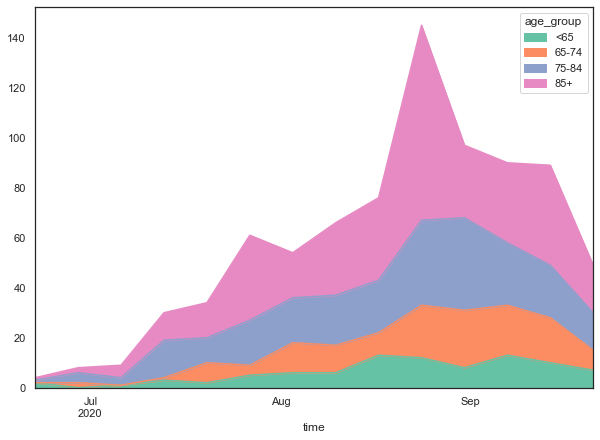

In [730]:
dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='area', figsize=(10,7), rot=0)

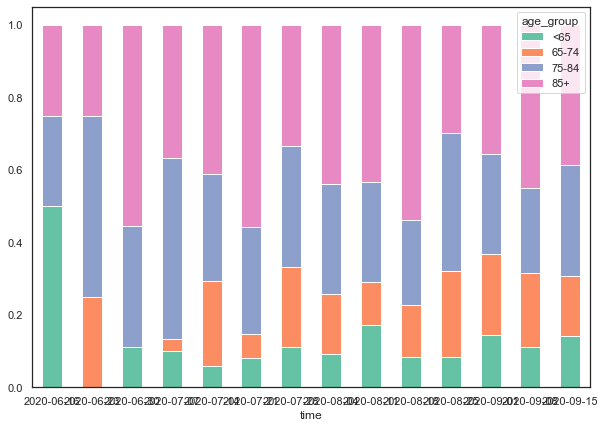

In [731]:
x = dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

In [732]:
dec_dif = decs.groupby(['time', 'Ventilated']).size().unstack().diff()

x = dec_dif.resample('7d', kind='period').sum()


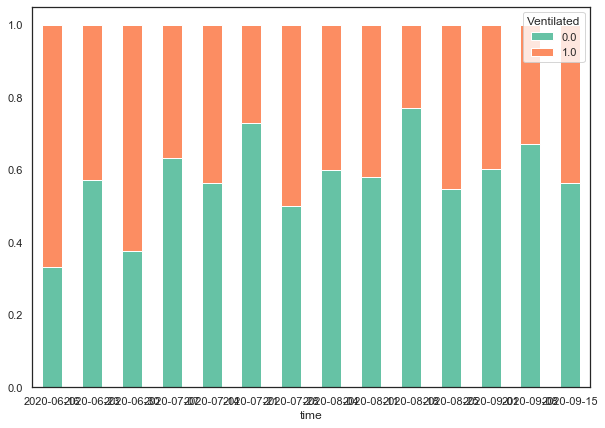

In [733]:
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

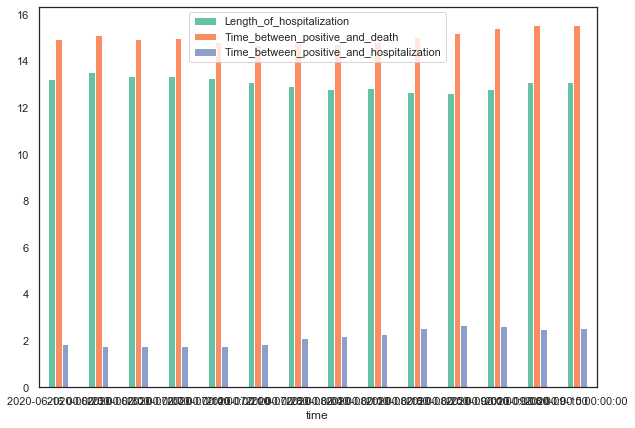

In [734]:
decs.resample('7d', on='time')[['Length_of_hospitalization', 'Time_between_positive_and_death', 'Time_between_positive_and_hospitalization']].mean().plot(kind='bar', figsize=(10,7), rot=0)


In [735]:
hos.head().T

0                    1  \
date                        2020-03-11 00:00:00  2020-03-12 00:00:00   
מאושפזים                                     76                   98   
אחוז נשים מאושפזות                         35.5                 38.8   
גיל ממוצע מאושפזים                           48                   50   
סטיית תקן גיל מאושפזים                     17.3                   18   
resp                                         15                   15   
אחוז נשים מונשמות                            20                   20   
גיל ממוצע מונשמים                            63                   63   
סטיית תקן גיל מונשמים                      15.3                 15.3   
חולים קל                                     69                   91   
אחוז נשים חולות קל                         36.2                 39.6   
גיל ממוצע חולים קל                           47                   49   
סטיית תקן גיל חולים קל                     16.7                 17.7   
medium                                       15                   15   
אחוז נשים חולות בינוני                      NaN                  NaN   
גיל ממוצע חולים בינוני                      NaN                  NaN   
סטיית תקן גיל חולים בינוני                  NaN                  NaN   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                 33.3   
גיל ממוצע חולים קשה                          67                   67   
סטיית תקן גיל חולים קשה                    16.2                 16.2   

                                              2                    3  \
date                        2020-03-13 00:00:00  2020-03-14 00:00:00   
מאושפזים                                    116                  154   
אחוז נשים מאושפזות                         38.8                 40.9   
גיל ממוצע מאושפזים                           49                   47   
סטיית תקן גיל מאושפזים                     17.9                 18.2   
resp                                         15                   15   
אחוז נשים מונשמות                            20                    0   
גיל ממוצע מונשמים                            63                   70   
סטיית תקן גיל מונשמים                      15.3                  7.4   
חולים קל                                    106                  145   
אחוז נשים חולות קל                         38.7                 41.4   
גיל ממוצע חולים קל                           47                   46   
סטיית תקן גיל חולים קל                     17.3                 17.4   
medium                                       15                   15   
אחוז נשים חולות בינוני                       50                   50   
גיל ממוצע חולים בינוני                       65                   65   
סטיית תקן גיל חולים בינוני                 17.3                 17.3   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                   20   
גיל ממוצע חולים קשה                          67                   76   
סטיית תקן גיל חולים קשה                    16.2                 10.3   

                                              4  
date                        2020-03-15 00:00:00  
מאושפזים                                    193  
אחוז נשים מאושפזות                           44  
גיל ממוצע מאושפזים                           47  
סטיית תקן גיל מאושפזים                     18.5  
resp                                         15  
אחוז נשים מונשמות                            20  
גיל ממוצע מונשמים                            74  
סטיית תקן גיל מונשמים                       7.6  
חולים קל                                    179  
אחוז נשים חולות קל                         44.1  
גיל ממוצע חולים קל                           45  
סטיית תקן גיל חולים קל                     17.5  
medium                                       15  
אחוז נשים חולות בינוני                       50  
גיל ממוצע חולים בינוני                       58  
סטיית תקן גיל חולים בינוני

In [736]:
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

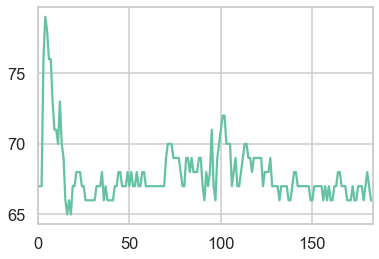

In [809]:
hos['גיל ממוצע חולים קשה'].plot()

## Recovered

In [737]:
pd.read_csv('data/corona_recovered_ver_004.csv.gz', encoding='1255')

days_between_pos_and_neg total_tests_count age_group gender  \
0                          8.0                 9     40-49   נקבה   
1                         19.0                 9     30-39    זכר   
2                         33.0                 9       60+    זכר   
3                         24.0                 9     30-39    זכר   
4                         20.0                 9     40-49    זכר   
...                        ...               ...       ...    ...   
6408                       NaN               NaN       60+    זכר   
6409                       NaN               NaN       60+   נקבה   
6410                       NaN               NaN       60+   נקבה   
6411                       NaN               NaN       60+    זכר   
6412                       NaN               NaN       60+    זכר   

             test_indication  
0     Contact with confirmed  
1     Contact with confirmed  
2                     Abroad  
3     Contact with confirmed  
4                     Abroad  
...                      ...  
6408                   Other  
6409  Contact with confirmed  
6410  Contact with confirmed  
6411                  Abroad  
6412                  Abroad  

[6413 rows x 5 columns]

In [738]:
recs = []
for file in sorted(glob.glob('data/corona_recovered*.csv.gz'), key=os.path.getctime) :
    try:
        r = pd.read_csv(file, 
                  encoding='1255', low_memory=False)
    except:
        r = pd.read_csv(file, 
                  encoding='utf-8', low_memory=False)
    print(file, pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False))
    r['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    r['file'] = file
    recs.append(r)

recs = pd.concat(recs)
recs['ver'] = recs.file.str.extract('ver_0+([1-9][0-9]*)').astype(int)
recs = recs.sort_values('ver')
recs.head()

data\corona_recovered_ver_0010.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_0012.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_004.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_005.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_006.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_007.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_008.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_0016.csv.gz 2020-06-10 10:31:01
data\corona_recovered_ver_0017.csv.gz 2020-06-11 13:45:44
data\corona_recovered_ver_0018.csv.gz 2020-06-16 12:09:51
data\corona_recovered_ver_0020.csv.gz 2020-06-19 12:31:14
data\corona_recovered_ver_0021.csv.gz 2020-06-22 19:27:14
data\corona_recovered_ver_0023.csv.gz 2020-06-28 07:56:06
data\corona_recovered_ver_0024.csv.gz 2020-06-29 09:30:26
data\corona_recovered_ver_0025.csv.gz 2020-07-02 08:39:47
data\corona_recovered_ver_0026.csv.gz 2020-07-07 11:13:23
data\corona_recovered_ver_0031.csv.gz 2020-07-12 15:47:27
data\corona_recover

days_between_pos_and_neg total_tests_count age_group gender  \
4923                      12.0                 3     30-39   נקבה   
4281                      15.0                 3     40-49   נקבה   
4280                       4.0                 3     20-29   נקבה   
4279                      13.0                 3     50-59    זכר   
4278                       7.0                 3     30-39   נקבה   

     test_indication                time  \
4923           Other 2020-05-30 14:05:58   
4281           Other 2020-05-30 14:05:58   
4280           Other 2020-05-30 14:05:58   
4279           Other 2020-05-30 14:05:58   
4278          Abroad 2020-05-30 14:05:58   

                                      file  ver  
4923  data\corona_recovered_ver_004.csv.gz    4  
4281  data\corona_recovered_ver_004.csv.gz    4  
4280  data\corona_recovered_ver_004.csv.gz    4  
4279  data\corona_recovered_ver_004.csv.gz    4  
4278  data\corona_recovered_ver_004.csv.gz    4

In [739]:
recs.ver.value_counts()

35    23651
34    21193
33    19878
32    18529
31    17913
26    16922
25    16427
24    16158
23    15883
21    15650
20    15485
18    15383
17    15254
16    15139
12    13863
10    12841
8     11251
7     10828
6      9419
5      8492
4      6413
Name: ver, dtype: int64

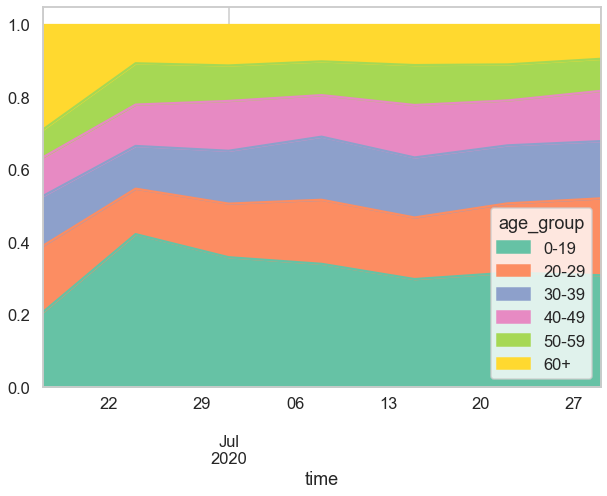

In [740]:
sns.set_style('whitegrid')
sns.set_context('talk')

rec_dif = recs[recs.ver>=17].groupby(['time', 'age_group']).size().unstack().diff()
rec_dif
x=rec_dif.resample('7d', kind='period').sum()

x.div(x.sum(axis=1),axis=0).plot(kind='area', figsize=(10,7), rot=0)

## Age & Gender

In [741]:
import gzip

def get_sep(path, encoding='utf-8'):
    if '.gz' in path:
        my_open=gzip.open
    else:
        my_open=open
    with my_open(path, 'rt', encoding=encoding) as f:
        first_line = f.readline()
    if '\t' in first_line:
        sep='\t'
    else:
        sep=','
    return sep

def get_latest_df(prefix, data_folder='data', suffix='*.csv.gz'):
    pat = os.path.join(data_folder, prefix+suffix)
    latest = get_latest_file_glob(pat)
    
    try:
        sep = get_sep(latest, '1255')
        df = pd.read_csv(latest, 
                  encoding='1255', low_memory=False, sep=sep)
    except:
        sep = get_sep(latest, 'utf-8-sig')
        df = pd.read_csv(latest, 
                  encoding='utf-8-sig', low_memory=False, sep=sep)
    return df
                
ag = get_latest_df('corona_age_and_gender')
ag.head()
    

first_week_day last_week_day age_group   gender weekly_tests_num  \
0     2020-03-15    2020-03-21      0-19      זכר           1104.0   
1     2020-03-15    2020-03-21      0-19     נקבה            917.0   
2     2020-03-15    2020-03-21      0-19  לא ידוע             39.0   
3     2020-03-15    2020-03-21     20-24  לא ידוע              <15   
4     2020-03-15    2020-03-21     20-24     נקבה            631.0   

  weekly_newly_tested weekly_cases weekly_deceased  
0              1053.0         37.0             0.0  
1               880.0         40.0             0.0  
2                39.0          0.0             0.0  
3                 <15          0.0             0.0  
4               611.0         36.0             0.0

In [742]:
ag.weekly_deceased.value_counts()

0.0     922
<15     226
26.0      4
33.0      3
22.0      2
15.0      2
19.0      2
25.0      1
23.0      1
16.0      1
18.0      1
31.0      1
20.0      1
27.0      1
21.0      1
35.0      1
Name: weekly_deceased, dtype: int64

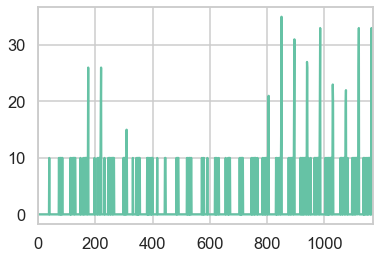

In [743]:
ag.weekly_deceased.replace('<15','10').astype(float).astype(int).plot()

## Dashboard Data

In [830]:
dash_folder = 'dashboard_data'
city_file_name = 'contagionDataPerCityPublic.csv'

In [831]:
city_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            if os.path.isdir(tfolder):
                city_df = city_df.append(pd.read_csv(os.path.join(tfolder, city_file_name)), sort=False)
                
city_df['date'] = pd.to_datetime(city_df.date)
city_df.head()

city sickCount actualSick verifiedLast7Days  testLast7Days  \
0        ירושלים     16214       3748              1266          13868   
1        בני ברק      9144       1252               482           3043   
2  מודיעין עילית      3122       1085               475           2004   
3            רהט       780        240               118            792   
4       כפר קאסם       455        185               109            501   

   patientDiffPopulationForTenThousands                             status  \
0                                    40  נדרשים הסברה, בדיקות ואכיפת בידוד   
1                                    62  נדרשים הסברה, בדיקות ואכיפת בידוד   
2                                   141  נדרשים הסברה, בדיקות ואכיפת בידוד   
3                                    36  נדרשים הסברה, בדיקות ואכיפת בידוד   
4                                    77  נדרשים הסברה, בדיקות ואכיפת בידוד   

                 lastUpdate                             date  
0  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
1  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
2  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
3  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
4  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00

In [832]:
city_df.dtypes

city                                                 object
sickCount                                            object
actualSick                                           object
verifiedLast7Days                                    object
testLast7Days                                         int64
patientDiffPopulationForTenThousands                  int64
status                                               object
lastUpdate                                           object
date                                    datetime64[ns, UTC]
dtype: object

In [833]:
city_tests = (city_df
              .groupby([pd.Grouper(key='date', freq='1d'), 'city'])['testLast7Days', 'verifiedLast7Days'].max()
              .assign(positive_rate = lambda x: x.verifiedLast7Days.replace('<15', '8').replace('1-5', '3').replace('6-10', '8').replace('11-14', '13').astype(int) / x.testLast7Days)
              .reset_index())
city_tests.head()

date                city  testLast7Days  \
0 2020-08-19 00:00:00+00:00  אבו ג'ווייעד (שבט)             12   
1 2020-08-19 00:00:00+00:00             אבו גוש            256   
2 2020-08-19 00:00:00+00:00            אבו סנאן            399   
3 2020-08-19 00:00:00+00:00   אבו קורינאת (שבט)             13   
4 2020-08-19 00:00:00+00:00   אבו רובייעה (שבט)             20   

  verifiedLast7Days  positive_rate  
0                 0       0.000000  
1                24       0.093750  
2                18       0.045113  
3                 0       0.000000  
4                 0       0.000000

In [834]:
#top_cities = city_tests.groupby('city').testLast7Days.mean().sort_values(ascending=False)[:20].index
from datetime import date, timedelta
yesterday = city_tests.date.max() - timedelta(days=1)
top_cities = city_tests[city_tests.date==yesterday].sort_values(by='testLast7Days', ascending=False).head(20).city

In [835]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='testLast7Days',
    size=alt.Size('positive_rate:Q', bin={'steps':[0.02,0.05,0.1]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [836]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).transform_joinaggregate(
     groupby = ['date'], TotalTests='sum(testLast7Days)',
).transform_calculate(
    PercentTests="datum.testLast7Days / datum.TotalTests"
).mark_area().encode(
    x='date',
    y='PercentTests:Q',
    color='city',
    #size='mean(positive_rate)',
    tooltip=['date', 'city', 'PercentTests:Q']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [837]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='positive_rate',
    size=alt.Size('testLast7Days', bin={'steps':[1000,2000,5000,10000]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [838]:
ct_change = (city_tests[city_tests.date.isin(['2020-08-31',yesterday.strftime('%Y-%m-%d') ])]
 .assign(date = lambda x: x.date.dt.strftime('%Y-%m-%d'))            
 .pivot(index='city', columns='date')[['testLast7Days', 'positive_rate']]
 .assign(test_ratio=lambda x: (x.iloc[:, 1]/x.iloc[:,0]).round(2))
 .assign(pr_ratio=lambda x: (x.iloc[:, 3]/x.iloc[:,2]).round(2))
 .assign(positive_rate = lambda x: x.positive_rate.round(2))
 .sort_values(by='test_ratio', ascending=False)
 
 )
ct_change[ct_change[('testLast7Days', yesterday.strftime('%Y-%m-%d'))]>=300].head(30)#.loc[list(top_cities), :]


testLast7Days            positive_rate            test_ratio  \
date                2020-08-31 2020-09-20    2020-08-31 2020-09-20              
city                                                                            
פקיעין (בוקייעה)           124        851          0.06       0.11       6.86   
שדרות                      362       2375          0.04       0.07       6.56   
ירוחם                      116        755          0.03       0.04       6.51   
מג'דל שמס                  103        531          0.08       0.08       5.16   
קרית שמונה                 297       1434          0.04       0.09       4.83   
חצור הגלילית                75        351          0.11       0.07       4.68   
עראבה                      347       1460          0.02       0.09       4.21   
יבנה                       521       2107          0.08       0.13       4.04   
גבעת שמואל                 302       1173          0.07       0.04       3.88   
בענה                       172        656          0.12       0.19       3.81   
באר יעקב                   311       1179          0.08       0.12       3.79   
עיילבון                     94        342          0.09       0.11       3.64   
דייר אל-אסד                164        585          0.09       0.20       3.57   
שוהם                       269        960          0.07       0.05       3.57   
קרית יערים                 148        527          0.05       0.06       3.56   
אריאל                      206        732          0.01       0.08       3.55   
פוריידיס                   178        625          0.18       0.16       3.51   
ירכא                       278        961          0.14       0.10       3.46   
נתיבות                     871       2979          0.11       0.13       3.42   
טמרה                       623       2052          0.05       0.14       3.29   
גן יבנה                    272        889          0.03       0.07       3.27   
להבים                      107        349          0.03       0.05       3.26   
נס ציונה                   488       1560          0.05       0.08       3.20   
אשקלון                    2183       6871          0.08       0.07       3.15   
גבעת זאב                   332       1038          0.07       0.13       3.13   
ג'ולס                      133        412          0.10       0.16       3.10   
אופקים                     637       1967          0.08       0.13       3.09   
יקנעם עילית                256        787          0.05       0.08       3.07   
כאבול                      213        648          0.04       0.10       3.04   
כפר מנדא                   172        521          0.17       0.22       3.03   

                 pr_ratio  
date                       
city                       
פקיעין (בוקייעה)     1.64  
שדרות                1.53  
ירוחם                1.54  
מג'דל שמס            0.97  
קרית שמונה           2.04  
חצור הגלילית         0.67  
עראבה                3.86  
יבנה                 1.63  
גבעת שמואל           0.53  
בענה                 1.54  
באר יעקב             1.47  
עיילבון              1.31  
דייר אל-אסד          2.22  
שוהם                 0.73  
קרית יערים           1.19  
אריאל                5.72  
פוריידיס             0.86  
ירכא                 0.75  
נתיבות               1.24  
טמרה                 2.90  
גן יבנה              2.52  
להבים                1.74  
נס ציונה             1.88  
אשקלון               0.96  
גבעת זאב             1.80  
ג'ולס                1.66  
אופקים               1.72  
יקנעם עילית          1.55  
כאבול                2.75  
כפר מנדא             1.25

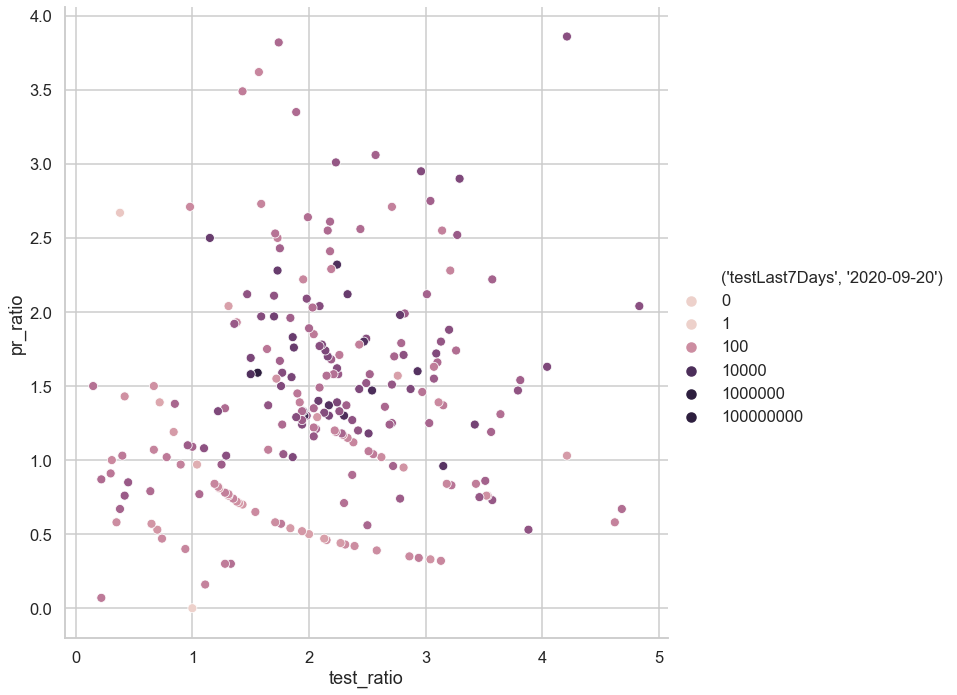

In [839]:
from matplotlib.colors import LogNorm

sns.relplot(data=ct_change[(ct_change.test_ratio<5) & (ct_change.pr_ratio<4)], x='test_ratio', y='pr_ratio', 
            hue=('testLast7Days', yesterday.strftime('%Y-%m-%d')), hue_norm=LogNorm(),
            height=10)

In [840]:
tr_file_name = 'testResultsPerDate.csv'

In [841]:
tr_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            if os.path.isdir(tfolder):
                tr_df = tr_df.append(pd.read_csv(os.path.join(tfolder, tr_file_name)), sort=False)
                
tr_df['date'] = pd.to_datetime(tr_df.date)
tr_df.tail()

date  amount  amountVirusDiagnosis  positiveAmount  \
229 2020-09-17 00:00:00+00:00   58681                 57336            5375   
230 2020-09-18 00:00:00+00:00   54403                 53166            5307   
231 2020-09-19 00:00:00+00:00   42829                 41772            3790   
232 2020-09-20 00:00:00+00:00   24469                 23491            2568   
233 2020-09-21 00:00:00+00:00    3348                  3201             381   

                   lastUpdate  
229  2020-09-21T06:42:02.463Z  
230  2020-09-21T06:42:02.463Z  
231  2020-09-21T06:42:02.463Z  
232  2020-09-21T06:42:02.463Z  
233  2020-09-21T06:42:02.463Z

In [842]:
tr_df.dtypes

date                    datetime64[ns, UTC]
amount                                int64
amountVirusDiagnosis                  int64
positiveAmount                        int64
lastUpdate                           object
dtype: object

In [843]:
tr = (tr_df.sort_values('lastUpdate', ascending=False)
              .groupby(['date']).head(1)
              .sort_values('date')
     .assign(positive_rate = lambda x: x.positiveAmount/x.amountVirusDiagnosis))
tr.tail()

date  amount  amountVirusDiagnosis  positiveAmount  \
229 2020-09-17 00:00:00+00:00   58681                 57336            5375   
230 2020-09-18 00:00:00+00:00   54403                 53166            5307   
231 2020-09-19 00:00:00+00:00   42829                 41772            3790   
232 2020-09-20 00:00:00+00:00   24469                 23491            2568   
233 2020-09-21 00:00:00+00:00    3348                  3201             381   

                   lastUpdate  positive_rate  
229  2020-09-21T06:42:02.463Z       0.093746  
230  2020-09-21T06:42:02.463Z       0.099819  
231  2020-09-21T06:42:02.463Z       0.090731  
232  2020-09-21T06:42:02.463Z       0.109318  
233  2020-09-21T06:42:02.463Z       0.119025